<a href="https://colab.research.google.com/github/ShantanuKadam3115/MachineLearningBasics/blob/ML_implementations/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
--- Starting Training ---
Epoch 1/15 | Loss: 1.5099 | LR: 0.001000
Epoch 2/15 | Loss: 1.2023 | LR: 0.001000
Epoch 3/15 | Loss: 1.1068 | LR: 0.001000
Epoch 4/15 | Loss: 1.0293 | LR: 0.001000
Epoch 5/15 | Loss: 0.9905 | LR: 0.001000
Epoch 6/15 | Loss: 0.9459 | LR: 0.001000
Epoch 7/15 | Loss: 0.9119 | LR: 0.001000
Epoch 8/15 | Loss: 0.8895 | LR: 0.001000
Epoch 9/15 | Loss: 0.8636 | LR: 0.001000
Epoch 10/15 | Loss: 0.8503 | LR: 0.000100
Epoch 11/15 | Loss: 0.7748 | LR: 0.000100
Epoch 12/15 | Loss: 0.7619 | LR: 0.000100
Epoch 13/15 | Loss: 0.7524 | LR: 0.000100
Epoch 14/15 | Loss: 0.7502 | LR: 0.000100
Epoch 15/15 | Loss: 0.7405 | LR: 0.000100


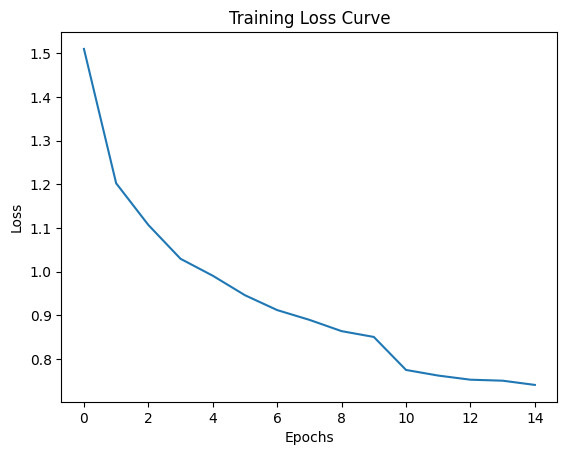


Final Accuracy on Test Set: 76.65%


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION & DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. DATA AUGMENTATION (The 'Gym' for AI) ---
# We make the training data harder so the model learns robustness.
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Mean/Std of CIFAR10

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Flip image left-right
    transforms.RandomCrop(32, padding=4),   # Shift image slightly
    transforms.ToTensor(),
    transforms.Normalize(*stats)            # Center data around 0
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Download Data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# --- 3. THE ARCHITECTURE ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Block 1: 3 -> 32 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # BN acts on the 32 channels
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Cuts size in half

        # Block 2: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Fully Connected Layer
        # Image is now 8x8 with 64 channels
        self.flatten_dim = 64 * 8 * 8
        self.fc = nn.Linear(self.flatten_dim, 10)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x) # 32x32 -> 16x16

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x) # 16x16 -> 8x8

        # Flatten
        x = x.view(-1, self.flatten_dim) # Reshape to (Batch, 4096)

        # Classifier
        x = self.fc(x)
        return x

# --- 4. TRAINING SETUP ---
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
# Every 10 epochs, multiply LR by 0.1 (Decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# --- 5. TRAINING LOOP ---
epochs = 15
train_losses = []

print("--- Starting Training ---")
for epoch in range(epochs):
    running_loss = 0.0
    model.train() # Set mode to Train (enables Dropout/BN)

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# --- 6. VISUALIZATION ---
plt.plot(train_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# --- 7. TEST ACCURACY ---
correct = 0
total = 0
model.eval() # Set mode to Eval (freezes BN stats)
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nFinal Accuracy on Test Set: {100 * correct / total:.2f}%')